In [5]:
import copy
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
from mitiq import zne
from qiskit import (IBMQ, ClassicalRegister, QuantumCircuit, QuantumRegister,
                    execute, transpile)
from qiskit.circuit import Parameter
from qiskit.providers.aer import AerSimulator  , QasmSimulator
from qiskit import Aer
from qiskit.utils.mitigation.fitters import (CompleteMeasFitter,
                                             TensoredMeasFitter)

from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

from lib import util

#from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise

In [6]:
#from qiskit.test.mock import FakeKolkata
#IBMQ.disable_account()
#provider = IBMQ.enable_account('7256e8255489fcd0cae6015bf2eeb8a50a9cc7aff36cfa2dbdb31d0f68fd80db9e472356560f160725266a0e16c022be8faf8e4fb7046f042795418841da0a0f')
#IBMQ.update_account()
print(IBMQ.providers())


provider = IBMQ.get_provider(hub='ibm-q-cern',group='infn', project='qcqcd2')


backend_sim_noisy_kolkata = QasmSimulator.from_backend(provider.get_backend('ibmq_kolkata'))
backend_real_kolkata = provider.get_backend('ibmq_kolkata')


backend_sim_ideal = Aer.get_backend('aer_simulator')
BACKEND=backend_sim_noisy_kolkata

noise_model = NoiseModel.from_backend(BACKEND)

# Get coupling map from backend
coupling_map = BACKEND.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-cern', group='infn', project='qcqcd2')>]


WARNING - Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
WARNING - Device model returned a depolarizing error parameter greater than maximum allowed value (1.067696 > 1.066667). Truncating to maximum value.
WARNING - Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
WARNING - Device model returned a depolarizing error parameter greater than maximum allowed value (1.067637 > 1.066667). Truncating to maximum value.
WARNING - Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
WARNING - Device model returned a depolarizing error parameter greater than maximum allowed value (1.067696 > 1.066667). Truncating to maximum value.
WARNING - Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
WARNIN

In [7]:
qubits_measure=[7,10,12,13,14,16,19]
qubits=qubits_measure
shots=10000
config=BACKEND.configuration()
N_qubits_backend=config.n_qubits
dt=0.08
#N_steps=15

In [8]:
qr=QuantumRegister(N_qubits_backend,name='q')
circuit=QuantumCircuit(qr)

for i in range (0,5):
    circuit.rz(dt/2,qr[qubits[i]])


    
circuit.cx(qr[qubits[2]],qr[qubits[3]])
circuit.cx(qr[qubits[1]],qr[qubits[2]])
circuit.cx(qr[qubits[0]],qr[qubits[1]])
circuit.cx(qr[qubits[4]],qr[qubits[3]])
circuit.cx(qr[qubits[5]],qr[qubits[4]])
circuit.cx(qr[qubits[6]],qr[qubits[5]])

circuit.rx(dt,qr[qubits[0]])
circuit.rx(dt,qr[qubits[6]])

circuit.cx(qr[qubits[6]],qr[qubits[5]])
circuit.cx(qr[qubits[5]],qr[qubits[4]])
circuit.cx(qr[qubits[4]],qr[qubits[3]])
circuit.cx(qr[qubits[0]],qr[qubits[1]])
circuit.cx(qr[qubits[1]],qr[qubits[2]])
circuit.cx(qr[qubits[2]],qr[qubits[3]])

for i in range (0,5):
    circuit.rz(dt/2,qr[qubits[i]])

circuit.draw()

»
 q_0: ───────────────────────────────────────────────────────────────»
                                                                     »
 q_1: ───────────────────────────────────────────────────────────────»
                                                                     »
 q_2: ───────────────────────────────────────────────────────────────»
                                                                     »
 q_3: ───────────────────────────────────────────────────────────────»
                                                                     »
 q_4: ───────────────────────────────────────────────────────────────»
                                                                     »
 q_5: ───────────────────────────────────────────────────────────────»
                                                                     »
 q_6: ───────────────────────────────────────────────────────────────»
      ┌──────────┐               ┌──────────┐            ┌──────────┐»
 q_7: ┤ Rz(0.04) ├────────────■──┤ Rx(0.08) ├─────■──────┤ Rz(0.04) ├»
      └──────────┘            │  └──────────┘     │      └──────────┘»
 q_8: ────────────────────────┼───────────────────┼──────────────────»
                              │                   │                  »
 q_9: ────────────────────────┼───────────────────┼──────────────────»
      ┌──────────┐          ┌─┴─┐               ┌─┴─┐                »
q_10: ┤ Rz(0.04) ├───────■──┤ X ├───────────────┤ X ├─────────■──────»
      └──────────┘       │  └───┘               └───┘         │      »
q_11: ───────────────────┼────────────────────────────────────┼──────»
      ┌──────────┐     ┌─┴─┐                                ┌─┴─┐    »
q_12: ┤ Rz(0.04) ├──■──┤ X ├────────────────────────────────┤ X ├────»
      ├──────────┤┌─┴─┐├───┤                                └───┘    »
q_13: ┤ Rz(0.04) ├┤ X ├┤ X ├─────────────────────────────────────────»
      ├──────────┤└───┘└─┬─┘┌───┐                                    »
q_14: ┤ Rz(0.04) ├───────■──┤ X ├────────────────────────────────────»
      └──────────┘          └─┬─┘                                    »
q_15: ────────────────────────┼──────────────────────────────────────»
                              │     ┌───┐                   ┌───┐    »
q_16: ────────────────────────■─────┤ X ├───────────────────┤ X ├────»
                                    └─┬─┘                   └─┬─┘    »
q_17: ────────────────────────────────┼───────────────────────┼──────»
                                      │                       │      »
q_18: ────────────────────────────────┼───────────────────────┼──────»
                                      │      ┌──────────┐     │      »
q_19: ────────────────────────────────■──────┤ Rx(0.08) ├─────■──────»
                                             └──────────┘            »
q_20: ───────────────────────────────────────────────────────────────»
                                                                     »
q_21: ───────────────────────────────────────────────────────────────»
                                                                     »
q_22: ───────────────────────────────────────────────────────────────»
                                                                     »
q_23: ───────────────────────────────────────────────────────────────»
                                                                     »
q_24: ───────────────────────────────────────────────────────────────»
                                                                     »
q_25: ───────────────────────────────────────────────────────────────»
                                                                     »
q_26: ───────────────────────────────────────────────────────────────»
                                                                     »
«                                               
« q_0: ─────────────────────────────────────────
«                                               
« q_1: ──────────

In [9]:
def final_circ(N_trot):
    qr=QuantumRegister(N_qubits_backend,name='q')
    qc=QuantumCircuit(qr)

    for i in range (0,N_trot):
        qc.append(circuit,qr)
    return qc

In [10]:
backend=backend_sim_ideal
qr = QuantumRegister(N_qubits_backend)
meas_calibs, state_labels = util.qiskit_calibration_circuits(N_qubits_backend,qubits_measure=qubits_measure)
print(len(meas_calibs))
job_cal = execute(meas_calibs, Aer.get_backend('qasm_simulator'),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model)
#job_cal.queue_position(refresh=True)
cal_results = job_cal.result()
cal_counts=cal_results.get_counts()
#print(cal_counts)
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

128


In [11]:
def circs_run(circs,qcirc,backend=BACKEND,qubits_measure=qubits_measure):
    
    qcirc=transpile(qcirc,backend,optimization_level=0)
    cal_circs_meas, s_labels = util.qiskit_calibration_circuits(N_qubits_backend,qubits_measure=qubits_measure)
    cal_circs_GEM, s_labels = util.GEM_calibration_circuits(qc=qcirc,qubits_measure=qubits_measure)

    circs += cal_circs_meas
    print(len(cal_circs_meas))
    circs += cal_circs_GEM[0]
    
    print(len(cal_circs_GEM[0]))
    circs += cal_circs_GEM[1]
    print(len(cal_circs_GEM[1]))
    #print(cal_circs_GEM[1][0].count_ops())

    qr_aux=QuantumRegister(N_qubits_backend,name='q')
    cr=ClassicalRegister(len(qubits_measure))
    qc=QuantumCircuit(qr_aux,cr)

    qc.append(qcirc,qr_aux)
    qc=transpile(qc,backend,optimization_level=0)
    for i in range (0,len(qubits_measure)):
        qc.measure([qr_aux[qubits_measure[i]]],[cr[i]])
    circs.append(qc)

    

    return circs,s_labels


In [12]:
def simulation(N_steps):

    circs=[]
    circs,s_labels=circs_run(circs,final_circ(N_steps))
    print(len(circs))
    '''
    job=execute(circs,Aer.get_backend('qasm_simulator'),
                    coupling_map=coupling_map,
                    basis_gates=basis_gates,
                    noise_model=noise_model,
                    shots=shots,
                    optimization_level=0)
    '''
    job=execute(circs,BACKEND,
                    shots=shots,
                    optimization_level=0)    
        
    job_result=job.result()
    job_counts=job_result.get_counts()
    job_qiskit=copy.deepcopy(cal_results)
    job_GEM_L=copy.deepcopy(cal_results)
    job_GEM_R=copy.deepcopy(cal_results)
    for j in range (0,len(s_labels)):
        job_qiskit.results[j].data.counts=job_counts[j]
    meas_fitter=CompleteMeasFitter(job_qiskit,s_labels)
    C_qiskit=meas_fitter.cal_matrix
    for j in range (0,len(s_labels)):
        job_GEM_L.results[j].data.counts=meas_fitter.filter.apply(job_counts[j+len(s_labels)],method="least_squares")
        job_GEM_R.results[j].data.counts=meas_fitter.filter.apply(job_counts[j+2*len(s_labels)],method="least_squares")

    meas_fitter_GEM_L = CompleteMeasFitter(job_GEM_L, state_labels=s_labels)
    meas_fitter_GEM_R = CompleteMeasFitter(job_GEM_R, state_labels=s_labels)
    Cal_GEM_L = meas_fitter_GEM_L.cal_matrix
    Cal_GEM_R = meas_fitter_GEM_R.cal_matrix
    C=(Cal_GEM_L+Cal_GEM_R)/2
        
        #define the equilibrium counts distribution
    rand_vec_prob=np.sum(C,axis=1,dtype='float')/(len(s_labels))
        
        
        #calculate the probaabilities of dep error
    p_t=(C[0][0]-1)/(rand_vec_prob[0]-1)
    print('p_t')
    print(p_t)

        #define the random prob vector and equilibrium prob vector
    print('rand_vec')
    print(rand_vec_prob)
    rand_vec=p_t*shots*rand_vec_prob

    D=np.zeros((len(s_labels),len(s_labels)))

    for k in range (0,len(s_labels)):
        for j in range (0,len(s_labels)):
            D[k][j]=(C[k][j]-p_t*rand_vec_prob[k])/(1-p_t)
    CGP=D
        
        
    meas_fitter_GP=copy.deepcopy(meas_fitter)
    meas_fitter_GP.cal_matrices=CGP

    meas_fitter_GEM=copy.deepcopy(meas_fitter)
    meas_fitter_GEM.cal_matrices=C

    job_counts_circ_raw=job_counts[-1]
    raw_vector=util.occurrences_to_vector(job_counts_circ_raw)
    new_vector_CGP=(raw_vector-rand_vec)/(1-p_t)
    new_counts=dict(zip(s_labels,new_vector_CGP))
    job_counts_circ_CGP=meas_fitter_GP.filter.apply(new_counts,method="least_squares")
    job_counts_circ_qiskit=meas_fitter.filter.apply(job_counts[-1],method="least_squares")
    job_counts_circ_GEM=meas_fitter_GEM.filter.apply(job_counts_circ_qiskit,method="least_squares")

    job_ideal=execute(circs[-1],backend=backend_sim_ideal,shots=shots,optimization_level=0)
    job_counts=job_ideal.result().get_counts()

    return job_counts_circ_raw,job_counts_circ_CGP,job_counts_circ_GEM,job_counts_circ_qiskit,job_counts,C,D,C_qiskit,p_t,rand_vec[0]


In [13]:
p_raw=[]
p_qiskit=[]
p_GEM=[]
p_CGP=[]
p_ideal=[]
C_GEM=[]
C_CGP=[]
C_qiskit=[]
p=[]
rand_vec=[]

for i in range (1,30):
    counts_raw,counts_CGP,counts_GEM,counts_qiskit,counts_ideal,C,G,Q,p_t,r=simulation(i)
    C_GEM.append(C)
    C_CGP.append(G)
    C_qiskit.append(Q)
    p.append(p_t)
    rand_vec.append(r)
    for output in ['0000000']:
        if output in counts_GEM:
            p_GEM.append(counts_GEM[output]/shots)
        else:
            p_GEM.append(0)
    
    for output in ['0000000']:
        if output in counts_raw:
            p_raw.append(counts_raw[output]/shots)
        else:
            p_raw.append(0)
    for output in ['0000000']:
        if output in counts_CGP:
            p_CGP.append(counts_CGP[output]/shots)
        else:
            p_CGP.append(0)
    for output in ['0000000']:
        if output in counts_qiskit:
            p_qiskit.append(counts_qiskit[output]/shots)
        else:
            p_qiskit.append(0)
    
    for output in ['0000000']:
        if output in counts_ideal:
            p_ideal.append(counts_ideal[output]/shots)
        else:
            p_ideal.append(0)


128
128
128
385
p_t
0.03918268869586223
rand_vec
[0.0084259  0.00823258 0.00800165 0.00796192 0.00803261 0.0077447
 0.00784107 0.00778997 0.00830809 0.00806641 0.00787803 0.00782971
 0.00804895 0.00784677 0.00779178 0.00782613 0.00827835 0.00805631
 0.00783366 0.00775951 0.00791171 0.00778816 0.00769479 0.00769127
 0.00829447 0.0080036  0.00782866 0.00774845 0.00784262 0.00768433
 0.00774978 0.00770398 0.00823293 0.00805405 0.00787561 0.00778318
 0.00784305 0.00771387 0.00772189 0.00746951 0.00805327 0.0079856
 0.00768497 0.00762426 0.00789772 0.00761944 0.0076078  0.00757009
 0.00810275 0.00787059 0.00766411 0.00761325 0.00775597 0.00762224
 0.00754104 0.00749655 0.00810385 0.00789866 0.00775037 0.00772933
 0.00774087 0.0075762  0.00757281 0.00748053 0.00823122 0.00813213
 0.00792786 0.0078336  0.00791357 0.00774012 0.00767515 0.00781397
 0.00819337 0.00801717 0.00781568 0.00777839 0.00787319 0.00769426
 0.00776814 0.00769187 0.00816862 0.00790353 0.00762332 0.00765544
 0.00784978 0.0

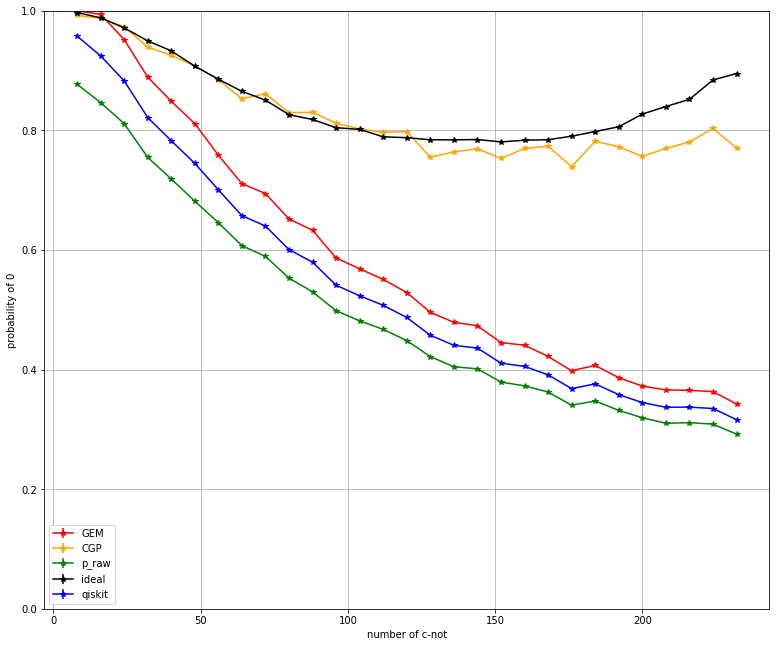

In [14]:

n=np.arange(1,len(p_GEM)+1,1)
n=n*8
db=0.000000001



plt.figure(figsize=(13,11))
plt.errorbar(n,p_GEM, db, linestyle='-', marker='*', color= 'red',label='GEM')
plt.errorbar(n,p_CGP, db, linestyle='-', marker='*', color= 'orange',label='CGP')
plt.errorbar(n,p_raw, db, linestyle='-', marker='*', color= 'green',label='p_raw')
plt.errorbar(n,p_ideal, db, linestyle='-', marker='*', color= 'black',label='ideal')
plt.errorbar(n,p_qiskit, db, linestyle='-', marker='*', color= 'blue',label='qiskit')



plt.xlabel('number of c-not')
plt.ylabel(r'probability of 0')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()

In [15]:
for i in range (0,len(rand_vec)):
    rand_vec[i]=rand_vec[i]/shots

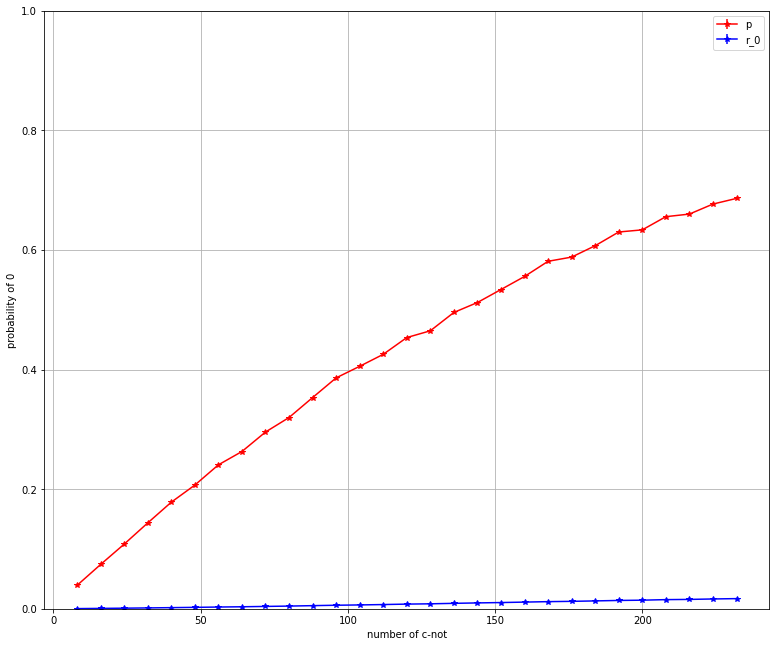

In [16]:
n=np.arange(1,len(p_GEM)+1,1)
n=n*8
db=0.000000001



plt.figure(figsize=(13,11))
plt.errorbar(n,p, db, linestyle='-', marker='*', color= 'red',label='p')
plt.errorbar(n,rand_vec, db, linestyle='-', marker='*', color= 'blue',label='r_0')

plt.xlabel('number of c-not')
plt.ylabel(r'probability of 0')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()

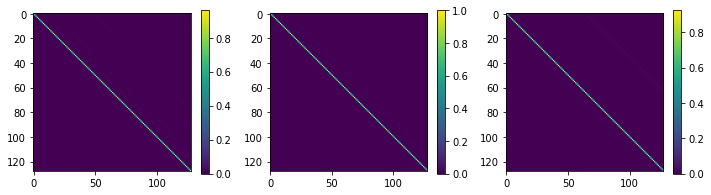

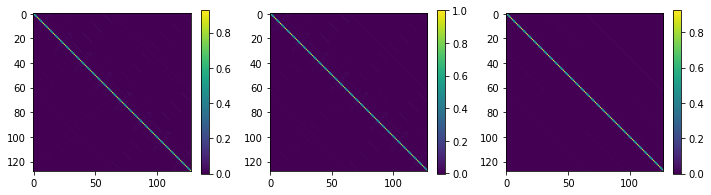

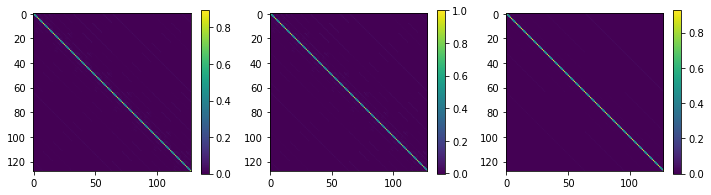

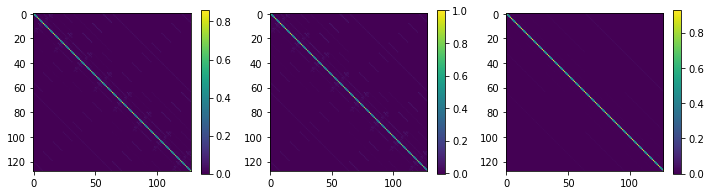

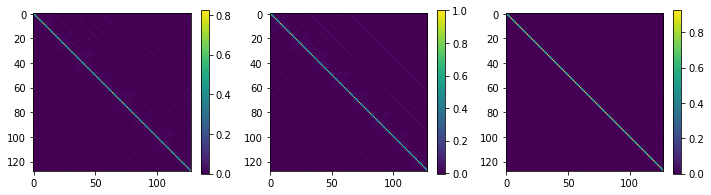

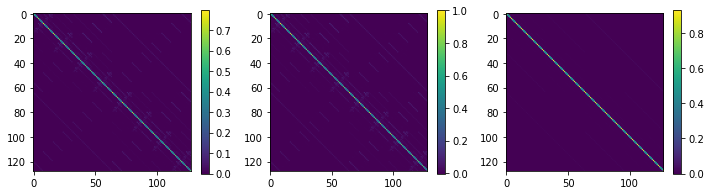

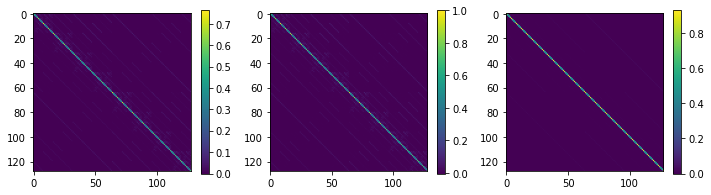

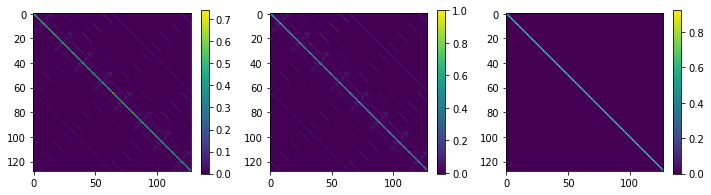

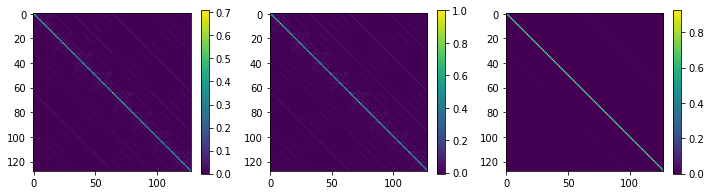

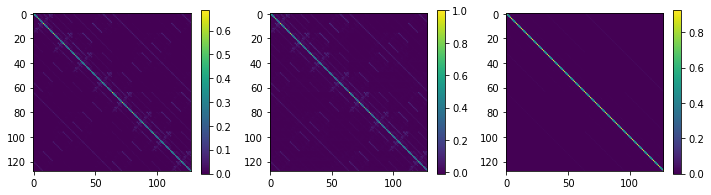

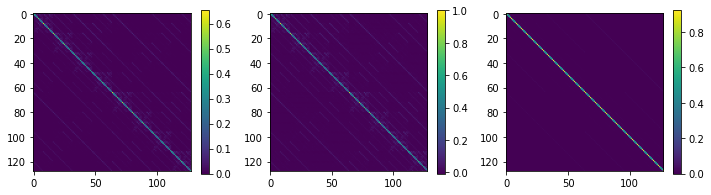

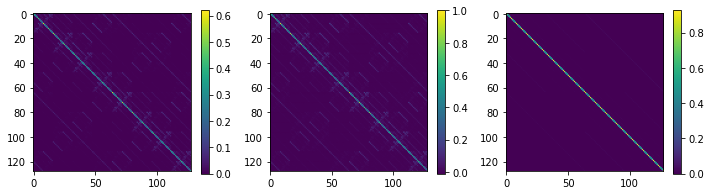

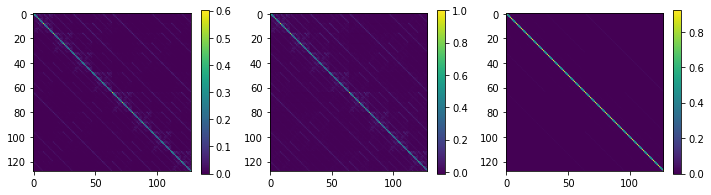

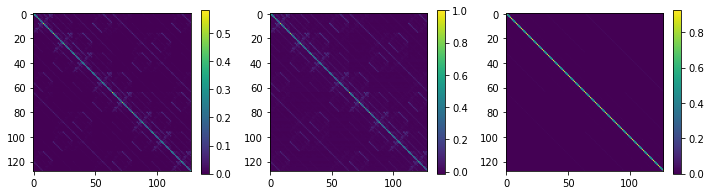

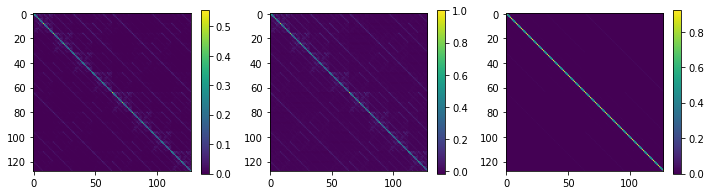

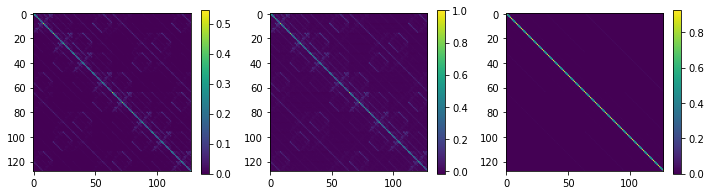

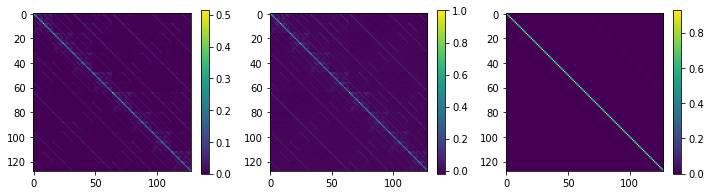

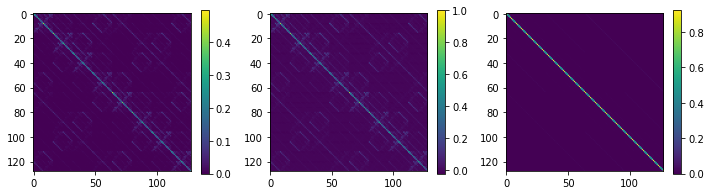

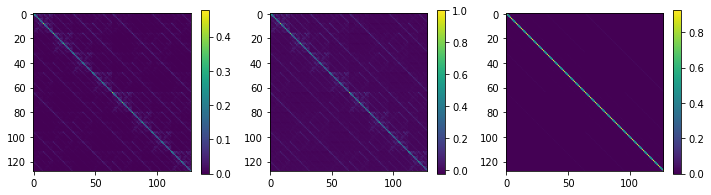

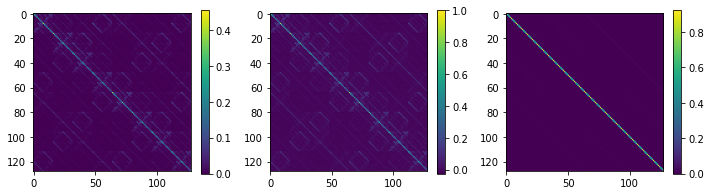

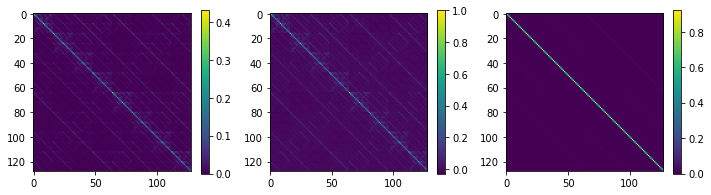

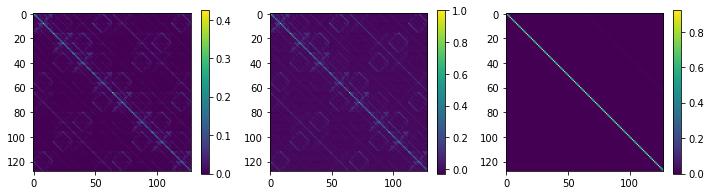

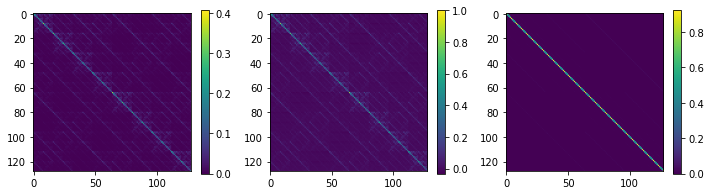

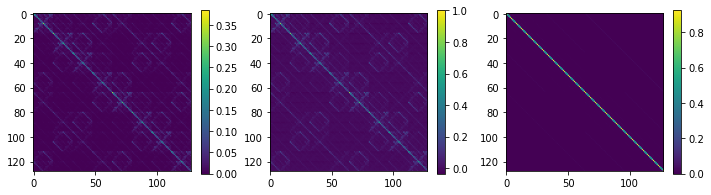

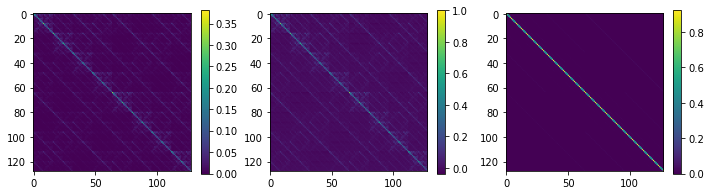

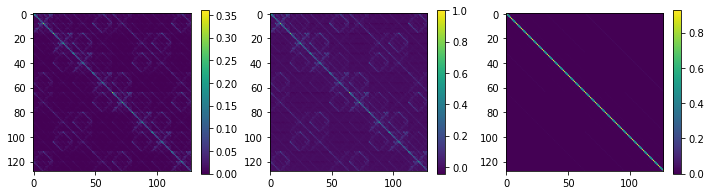

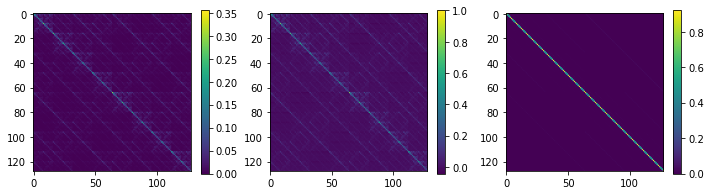

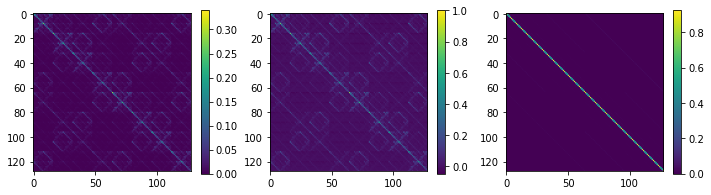

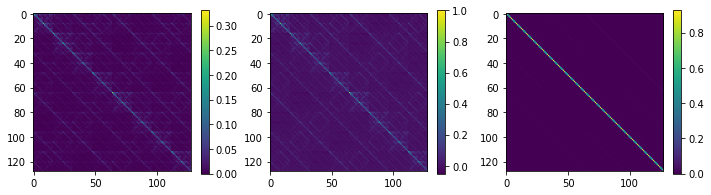

In [17]:
for i in range (0,len(C_GEM)):
    plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.imshow(C_GEM[i])
    plt.colorbar()
    plt.subplot(132)
    plt.imshow(C_CGP[i])
    plt.colorbar()
    plt.subplot(133)
    plt.imshow(C_qiskit[i])
    plt.colorbar()
    plt.show()